# Unstructured Data Analytics HW2

Name: Wenjia Hu

Andrew ID: wenjiah

Collaborators (if none, say "none"; do *not* leave this blank):
I use ChatGPT to identify syntax for some of my code and library

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [2]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [8]:
folder_path = '/Users/cmu-work/Code/CMU Class Code/95865_unstructure_data_analysis/HW2/data/enron'

# list all files in the folder
import os
file_list = os.listdir(folder_path)

full_path_list = []
for file in file_list:
    full_path_list.append(folder_path + '/' + file)

In [19]:
processed_doc_list = []
for path in full_path_list:
    processed_doc_list.append(make_word_list(path))

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [20]:
# construct a document-term matrix

# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# set min_df = 50,  stop_words = 'english', and max_df = 0.8
vectorizer = TfidfVectorizer(min_df=50, stop_words='english', max_df=0.8)

# fit and transform the documents
X = vectorizer.fit_transform(processed_doc_list)


In [34]:
# sanity check
# tfidf_matrix.shape

(5172, 1680)

In [24]:
# find the number of keys in the vocabulary
print("number of unique words in the vocabulary is: ", len(vectorizer.vocabulary_))

number of unique words in the vocabulary is:  1680


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [38]:
# cluster the documents using GaussianMixture
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=0).fit(X.toarray())


In [27]:
# Print the number of documents assigned to each cluster.
import numpy as np
unique, counts = np.unique(gmm.predict(X.toarray()), return_counts=True)
print(dict(zip(unique, counts)))

{0: 4479, 1: 365, 2: 328}


In [29]:
# quick sanity check
# len(processed_doc_list)

5172

### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [30]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

In [ ]:
vocabulary = vectorizer.vocabulary_




In [54]:
# identify the indices of the spam documents from TfidfVectorizer
spam_words = ['money', 'deal', 'www' ]
spam_indices = [vocabulary.get(i) for i in spam_words]
spam_indices


[940, 348, 1670]

In [57]:
# identify the indices of the ham documents
ham_words = ['meeting', 'plan', 'team']
ham_indices = [vocabulary.get(i) for i in ham_words]
ham_indices

[904, 1089, 1491]

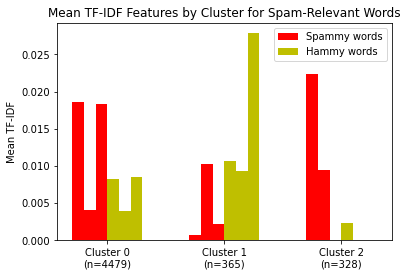

In [58]:
predicted = gmm.predict(X.toarray())
n_clusters = 3

plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices)

### Part E: Interpret results [10 points]|

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

#### Answer: 
Based on the result, when n = 3, cluster 1 (n=365) seems to correspond to typical business emails (ham), while cluster 2 (n=382) seems to correspond to marketing emails (spam)

n = 5 seem to be better than n = 2 in terms of locating clusters of spam emails.

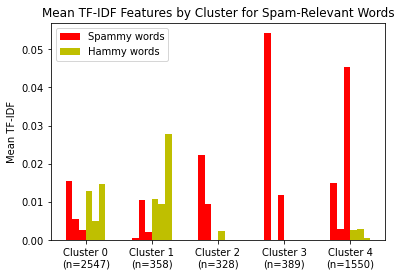

In [59]:
gmm = GaussianMixture(n_components=5, random_state=0).fit(X.toarray())

vocabulary = vectorizer.vocabulary_

# identify the indices of the spam documents from TfidfVectorizer
spam_words = ['money', 'deal', 'www' ]
spam_indices = [vocabulary.get(i) for i in spam_words]

# identify the indices of the ham documents
ham_words = ['meeting', 'plan', 'team']
ham_indices = [vocabulary.get(i) for i in ham_words]

predicted = gmm.predict(X.toarray())
n_clusters = 5

plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices)


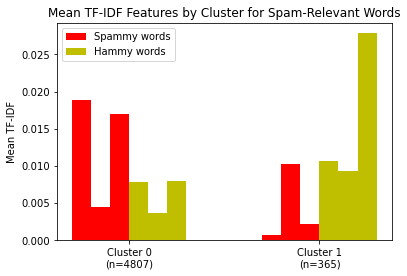

In [60]:
gmm = GaussianMixture(n_components=2, random_state=0).fit(X.toarray())

vocabulary = vectorizer.vocabulary_

# identify the indices of the spam documents from TfidfVectorizer
spam_words = ['money', 'deal', 'www' ]
spam_indices = [vocabulary.get(i) for i in spam_words]

# identify the indices of the ham documents
ham_words = ['meeting', 'plan', 'team']
ham_indices = [vocabulary.get(i) for i in ham_words]

predicted = gmm.predict(X.toarray())
n_clusters = 2

plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices)

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [2]:
df = pd.read_csv("/Users/cmu-work/Code/CMU Class Code/95865_unstructure_data_analysis/HW2/APR.csv", sep=",",  thousands=",")

In [3]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [4]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [5]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values


In [6]:
del df # uncomment to free up RAM
del df_perms # uncomment to free up RAM

In [7]:
len(app_names)

180295

In [8]:
permission_columns

['Default : Access DRM content. (S)',
 'Default : Access Email provider data (S)',
 'Default : Access all system downloads (S)',
 'Default : Access download manager. (S)',
 'Default : Advanced download manager functions. (S)',
 'Default : Audio File Access (S)',
 'Default : Install DRM content. (S)',
 'Default : Modify Google service configuration (S)',
 'Default : Modify Google settings (S)',
 'Default : Move application resources (S)',
 'Default : Read Google settings (S)',
 'Default : Send download notifications. (S)',
 'Default : Voice Search Shortcuts (S)',
 'Default : access SurfaceFlinger (S)',
 'Default : access checkin properties (S)',
 'Default : access the cache filesystem (S)',
 'Default : access to passwords for Google accounts (S)',
 'Default : act as an account authenticator (S)',
 'Default : bind to a wallpaper (S)',
 'Default : bind to an input method (S)',
 'Default : change screen orientation (S)',
 'Default : coarse (network-based) location (S)',
 'Default : control

In [9]:
X.shape

(180295, 173)

### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [10]:
# TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer

# transform the data
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X)

In [79]:
permission_columns

['Default : Access DRM content. (S)',
 'Default : Access Email provider data (S)',
 'Default : Access all system downloads (S)',
 'Default : Access download manager. (S)',
 'Default : Advanced download manager functions. (S)',
 'Default : Audio File Access (S)',
 'Default : Install DRM content. (S)',
 'Default : Modify Google service configuration (S)',
 'Default : Modify Google settings (S)',
 'Default : Move application resources (S)',
 'Default : Read Google settings (S)',
 'Default : Send download notifications. (S)',
 'Default : Voice Search Shortcuts (S)',
 'Default : access SurfaceFlinger (S)',
 'Default : access checkin properties (S)',
 'Default : access the cache filesystem (S)',
 'Default : access to passwords for Google accounts (S)',
 'Default : act as an account authenticator (S)',
 'Default : bind to a wallpaper (S)',
 'Default : bind to an input method (S)',
 'Default : change screen orientation (S)',
 'Default : coarse (network-based) location (S)',
 'Default : control

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [11]:
%%time

#  Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, random_state=0, n_jobs=-1)
lda.fit(X_tfidf)


CPU times: user 7.36 s, sys: 744 ms, total: 8.1 s
Wall time: 35.7 s


LatentDirichletAllocation(n_jobs=-1, random_state=0)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

#### Answer
Based on the top keywords, it seems like at least some of the applications clusters can be meaningfully interprated. For example 
   * Topic #0 - location, contact and personal contact based recommendation, thus it seem to be some kind of location-based applicatio
 

**Topic #0: - Seem to be some kind of location-based application**

Your location : coarse (network-based) location (D), Your location : fine (GPS) location (D), Network communication : full Internet access (D), Network communication : view network state (S), Phone calls : read phone state and identity (D), Services that cost you money : directly call phone numbers (D), Storage : modify/delete USB storage contents modify/delete SD card contents (D), Hardware controls : control vibrator (S), System tools : automatically start at boot (S), Your personal information : read Browser's history and bookmarks (D)


Topic #1: 

Hardware controls : control vibrator (S), Network communication : full Internet access (D), Network communication : view network state (S), Storage : modify/delete USB storage contents modify/delete SD card contents (D), System tools : disable keylock (D), Phone calls : read phone state and identity (D), System tools : prevent device from sleeping (D), Default : modify battery statistics (S), Default : change screen orientation (S), System tools : modify global system settings (D)


Topic #2: Network communication : full Internet access (D), Network communication : view network state (S), Default : partial shutdown (S), Network communication : download files without notification (S), Default : control system backup and restore (S), Your personal information : read contact data (D), Default : reset system to factory defaults (S), System tools : modify global system settings (D), Default : monitor and control all application launching (S), Your accounts : discover known accounts (S)

Topic #3: Your accounts : discover known accounts (S), Default : directly install applications (S), Storage : modify/delete USB storage contents modify/delete SD card contents (D), Your accounts : use the authentication credentials of an account (D), Network communication : view network state (S), Network communication : full Internet access (D), System tools : prevent device from sleeping (D), Your personal information : read contact data (D), Your personal information : write contact data (D), Hardware controls : control vibrator (S)


Topic #4: System tools : prevent device from sleeping (D), Storage : modify/delete USB storage contents modify/delete SD card contents (D), Network communication : full Internet access (D), Network communication : view network state (S), System tools : automatically start at boot (S), Phone calls : read phone state and identity (D), Hardware controls : control vibrator (S), System tools : change your UI settings (D), System tools : set wallpaper size hints (S), System tools : set wallpaper (S)
Topic #5: Storage : modify/delete USB storage contents modify/delete SD card contents (D), System tools : set wallpaper (S), Network communication : full Internet access (D), Network communication : view network state (S), Phone calls : read phone state and identity (D), System tools : mount and unmount filesystems (D), Default : bind to a wallpaper (S), Default : read phone state and identity (S), Default : access the cache filesystem (S), Default : discover known accounts (S)
Topic #6: Hardware controls : take pictures and videos (D), Storage : modify/delete USB storage contents modify/delete SD card contents (D), Hardware controls : record audio (D), Your location : fine (GPS) location (D), Your location : coarse (network-based) location (D), Network communication : full Internet access (D), Your location : access extra location provider commands (S), Network communication : view network state (S), Your location : mock location sources for testing (D), Hardware controls : control vibrator (S)
Topic #7: Network communication : view Wi-Fi state (S), Phone calls : read phone state and identity (D), Network communication : view network state (S), Network communication : full Internet access (D), Storage : modify/delete USB storage contents modify/delete SD card contents (D), System tools : change Wi-Fi state (D), Network communication : create Bluetooth connections (D), System tools : bluetooth administration (D), System tools : change network connectivity (D), System tools : allow Wi-Fi Multicast reception (D)
Topic #8: System tools : retrieve running applications (D), Phone calls : read phone state and identity (D), Services that cost you money : directly call phone numbers (D), Network communication : view network state (S), Network communication : receive data from Internet (S), Network communication : full Internet access (D), Storage : modify/delete USB storage contents modify/delete SD card contents (D), System tools : prevent device from sleeping (D), Your location : fine (GPS) location (D), Hardware controls : control vibrator (S)

Topic #9: Your personal information : read contact data (D), Services that cost you money : send SMS messages (D), System tools : modify global system settings (D), Phone calls : read phone state and identity (D), Your messages : receive SMS (D), Network communication : full Internet access (D), Your messages : read SMS or MMS (D), Phone calls : intercept outgoing calls (D), System tools : automatically start at boot (S), Your personal information : write contact data (D)


In [12]:
# list the top 10 words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

n_top_words = 10
print_top_words(lda, permission_columns, n_top_words)

Topic #0: Your location : coarse (network-based) location (D), Your location : fine (GPS) location (D), Network communication : full Internet access (D), Network communication : view network state (S), Phone calls : read phone state and identity (D), Services that cost you money : directly call phone numbers (D), Storage : modify/delete USB storage contents modify/delete SD card contents (D), Hardware controls : control vibrator (S), System tools : automatically start at boot (S), Your personal information : read Browser's history and bookmarks (D)
Topic #1: Hardware controls : control vibrator (S), Network communication : full Internet access (D), Network communication : view network state (S), Storage : modify/delete USB storage contents modify/delete SD card contents (D), System tools : disable keylock (D), Phone calls : read phone state and identity (D), System tools : prevent device from sleeping (D), Default : modify battery statistics (S), Default : change screen orientation (S)

*** WRITE YOUR ANSWER HERE IN TEXT ***

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [34]:
doc_topic_dist = lda.transform(X_tfidf)

In [35]:
# turn the topic distribution into a DataFrame
df_doc_topic_dist = pd.DataFrame(doc_topic_dist)

# add the app names
df_doc_topic_dist["App"] = app_names

# add the number of ratings
df_doc_topic_dist["Number of ratings"] = app_ratings

In [19]:
df_doc_topic_dist

,0,1,2,3,4,5,6,7,8,9,App,Number of ratings
0,0.018412,0.018413,0.018407,0.710073,0.018412,0.018407,0.018413,0.142626,0.018416,0.018421,Google Maps,1438259
1,0.019843,0.019846,0.019843,0.523399,0.019845,0.019843,0.019843,0.019842,0.019845,0.317850,Facebook for Android,1897622
2,0.023670,0.023669,0.023668,0.023679,0.023691,0.023667,0.023674,0.594844,0.215729,0.023710,Pandora?? internet radio,650856
3,0.028327,0.028329,0.028335,0.583973,0.028329,0.189381,0.028329,0.028328,0.028327,0.028343,Zedge Ringtones & Wallpapers,240408
4,0.374700,0.033243,0.033252,0.033248,0.033250,0.033244,0.033242,0.033244,0.359333,0.033246,Advanced Task Killer,344603
...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.023670,0.023669,0.023668,0.023679,0.023691,0.023667,0.023674,0.594844,0.215729,0.023710,Pandora® internet radio,659115
91,0.478908,0.022717,0.022708,0.271220,0.022735,0.090863,0.022710,0.022715,0.022712,0.022710,Dolphin Browser™ HD,219335
92,0.026394,0.026390,0.026392,0.026389,0.026404,0.026392,0.762467,0.026392,0.026391,0.026389,Brightest Flashlight Free™,139279
93,0.017476,0.017481,0.017476,0.136699,0.017488,0.017614,0.017475,0.017481,0.017483,0.723326,Handcent SMS,396166


In [24]:
# filter out the apps that have less than 100000 ratings
df_doc_topic_dist = df_doc_topic_dist[df_doc_topic_dist["Number of ratings"] >= 100000].reset_index(drop=True)

for i in range(10):
    print("Topic ", i)
    print(df_doc_topic_dist.sort_values(by=i, ascending=False).head(n=3)["App"].tolist())
    print()

Topic  0
['Toss It', 'Dictionary.com', 'Air Control Lite']

Topic  1
['Live Holdem Poker Pro', 'Vaulty Free Hides Pictures', 'Drag Racing']

Topic  2
['Yoo Ninja! Free', 'Angry Birds Seasons', 'Adobe Reader']

Topic  3
['Lookout Security & Antivirus', 'Antivirus Free', 'WhatsApp Messenger']

Topic  4
['Real BlackJack', 'ColorNote Notepad Notes', 'Robo Defense FREE']

Topic  5
['Paradise Island', 'World Newspapers', 'My Country']

Topic  6
['Brightest Flashlight Free™', 'Brightest Flashlight Free???', 'Tiny Flashlight + LED']

Topic  7
['Slice It!', 'Racing Moto', 'Blast Monkeys']

Topic  8
['TuneIn Radio', 'Restaurant Story???', 'Restaurant Story™']

Topic  9
['GO SMS Pro', 'chompSMS', 'PowerAMP Music Player (Trial)']



### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

In [36]:
# assign topics to each app
df_doc_topic_dist["Topic"] = df_doc_topic_dist.drop(["App", "Number of ratings"], axis=1).idxmax(axis=1)

# take a subset of the data that have 2000 rows
df_doc_topic_dist_subset = df_doc_topic_dist.sample(n=1000, random_state=42).reset_index(drop=True)

In [43]:
df_doc_topic_dist_subset.head(n=3)

,0,1,2,3,4,5,6,7,8,9,App,Number of ratings,Topic
0,0.050002,0.050004,0.050000,0.050002,0.050007,0.549970,0.050005,0.050004,0.050004,0.050002,Droid Subtitle,1,5
1,0.035404,0.035403,0.035421,0.035398,0.035403,0.035406,0.035399,0.035411,0.681355,0.035399,Ballroom Dancing Beginners Pt1,4,8
2,0.608804,0.029207,0.029187,0.029188,0.157651,0.029184,0.029188,0.029218,0.029188,0.029185,Devil Beastmaster,1,0


In [44]:
# make dimensionality reduction using t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(df_doc_topic_dist_subset.drop(["App", "Number of ratings", "Topic"], axis=1))

<ipython-input-45-a7d182543d91>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_doc_topic_dist_subset["Topic"].astype(int), cmap=plt.cm.get_cmap("jet", 10))


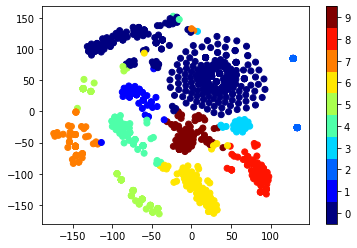

In [45]:
# visualize the X_tsne, using the topic as the color
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_doc_topic_dist_subset["Topic"].astype(int), cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://forms.gle/8i5htD6oXMr1nK958